In [3]:
from load_TSTCC import load_TSTCC
import os
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import mne
from torch.utils.data import Dataset, DataLoader
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from mne import io
from scipy.signal import find_peaks

In [ ]:
def get_edfs_per_subject(subject_ids, root_dir, label, one_file_per_subject=False):
    """
    For each subject, collect either all EDFs or just the first one.
    
    Args:
        subject_ids (list): List of subject ID folder names.
        root_dir (str): Path to the dataset root folder.
        label (int): Label to assign to this class (e.g., 0 = non-epileptic, 1 = epileptic).
        one_file_per_subject (bool): If True, only get one EDF per subject.
    
    Returns:
        List of tuples: [(edf_path, label), ...]
    """
    collected = []
    for subject_id in subject_ids:
        subject_root = os.path.join(root_dir, subject_id)
        edf_files = glob.glob(os.path.join(subject_root, '**', '*.edf'), recursive=True)

        if not edf_files:
            print(f" No EDF files found for subject: {subject_id}")
            continue

        if one_file_per_subject:
            collected.append((edf_files[0], label))
        else:
            collected.extend([(edf_path, label) for edf_path in edf_files])
    
    return collected

In [54]:
def read_ids(file_path):
    ids = []
    with open(file_path, 'r') as f:
        for line in f:
            id_only = line.strip().split()[0]
            ids.append(id_only)
    return ids

# Read subject IDs
epilepsy_ids = read_ids("00_subject_ids_epilepsy.list")
no_epilepsy_ids = read_ids("01_subject_ids_no_epilepsy.list")

# Root folders
epilepsy_root = "00_epilepsy"
no_epilepsy_root = "01_no_epilepsy"

# Toggle between all EDFs or one per subject
use_one_edf_per_subject = False

# Load paths
epilepsy_data = get_edfs_per_subject(epilepsy_ids, epilepsy_root, label=1, one_file_per_subject=use_one_edf_per_subject)
no_epilepsy_data = get_edfs_per_subject(no_epilepsy_ids, no_epilepsy_root, label=0, one_file_per_subject=use_one_edf_per_subject)

print(f"Found {len(epilepsy_data)} epilepsy files and {len(no_epilepsy_data)} non-epilepsy files.")


#Remove EDFs with <19 channels


def is_valid_edf(path, min_channels=19):
    try:
        raw = mne.io.read_raw_edf(path, preload=False, verbose=False)
        return raw.info['nchan'] >= min_channels
    except Exception as e:
        print(f" {path}  {e}")
        return False

# Combine and filter
all_data = epilepsy_data + no_epilepsy_data
filtered_data = [(p, y) for (p, y) in all_data if is_valid_edf(p)]

print(f"Kept {len(filtered_data)} valid EDFs after filtering.")

# Split paths and labels
all_paths, all_labels = zip(*filtered_data)


[WARN] No EDF files found for subject: aaaaamys
[WARN] No EDF files found for subject: aaaaaodl
[WARN] No EDF files found for subject: aaaaaphz
[WARN] No EDF files found for subject: aaaaaohu
[WARN] No EDF files found for subject: aaaaapap
Found 1728 epilepsy files and 508 non-epilepsy files.
Kept 2228 valid EDFs after filtering.


In [44]:
new_ep_ids = [[x, 1, epilepsy_root] for x in epilepsy_ids]
new_no_ep_ids = [[x, 0, no_epilepsy_root] for x in no_epilepsy_ids]
all_ids = new_ep_ids + new_no_ep_ids

train_ids, test_ids = train_test_split(all_ids, test_size=0.2, random_state=42, stratify=[x[1] for x in all_ids])
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42, stratify=[x[1] for x in train_ids])

train_data = [get_edfs_per_subject([x[0]], x[2], x[1], one_file_per_subject=False) for x in train_ids]
train_data = [item for sublist in train_data for item in sublist if len(item) > 0]  # Flatten the list
val_data = [get_edfs_per_subject([x[0]], x[2], x[1], one_file_per_subject=False) for x in val_ids]
val_data = [item for sublist in val_data for item in sublist if len(item) > 0]  # Flatten the list
test_data = [get_edfs_per_subject([x[0]], x[2], x[1], one_file_per_subject=False) for x in test_ids]
test_data = [item for sublist in test_data for item in sublist if len(item) > 0]  # Flatten the list

[WARN] No EDF files found for subject: aaaaaohu
[WARN] No EDF files found for subject: aaaaapap
[WARN] No EDF files found for subject: aaaaaphz
[WARN] No EDF files found for subject: aaaaamys
[WARN] No EDF files found for subject: aaaaaodl


In [45]:

class EEGDataset(Dataset):
    def __init__(self, edf_paths, labels, max_len=1000):
        self.edf_paths = edf_paths
        self.labels = labels
        self.max_len = max_len  # Max time points per sample

    def __len__(self):
        return len(self.edf_paths)

    def __getitem__(self, idx):
        path = self.edf_paths[idx]
        label = self.labels[idx]

        try:
            raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
            data = raw.get_data()
            data = data[:19]  # Use only 19 EEG channels (skip ECG, EOG, etc.)
            if data.shape[1] < self.max_len:
                # Pad with zeros if shorter than max_len
                padding = np.zeros((data.shape[0], self.max_len - data.shape[1]))
                data = np.hstack((data, padding))
            elif data.shape[1] > self.max_len:
                # Truncate if longer than max_len
                data = data[:, :self.max_len]
        except Exception as e:
            print(f"[ERROR] Could not load {path}: {e}")
            data = np.zeros((19, self.max_len))  # fallback

        # Normalize
        data = (data - np.mean(data)) / (np.std(data) + 1e-6)
        length = data.shape[1]
        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(length, dtype=torch.long)




In [ ]:
train_paths, train_labels = zip(*train_data)
val_paths, val_labels = zip(*val_data)
test_paths, test_labels = zip(*test_data)
print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_ds = EEGDataset(train_paths, train_labels)
val_ds = EEGDataset(val_paths, val_labels)
test_ds = EEGDataset(test_paths, test_labels)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)

Train: 1475, Val: 433, Test: 328
Using device: cuda


C:\Users\filip\AppData\Local\Temp\ipykernel_34208\1110738062.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  split = torch.load("preprocessed/split_index.pt")


### NULL model

Null Model Accuracy: 85.19%
               precision    recall  f1-score   support

Non-Epileptic       0.00      0.00      0.00        48
    Epileptic       0.85      1.00      0.92       276

     accuracy                           0.85       324
    macro avg       0.43      0.50      0.46       324
 weighted avg       0.73      0.85      0.78       324



c:\Users\filip\miniconda3\envs\eeg-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\miniconda3\envs\eeg-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\miniconda3\envs\eeg-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

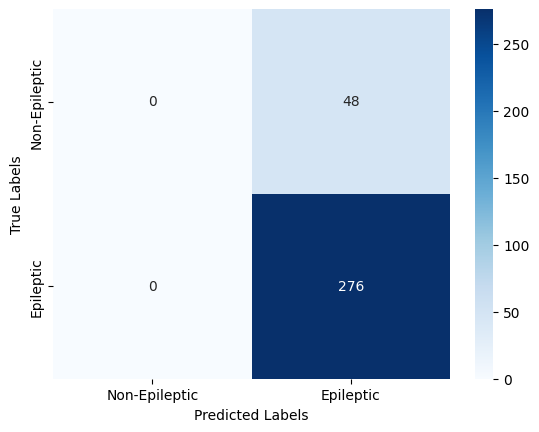

In [10]:
# Step 1: Create and fit the null model
null_model = DummyClassifier(strategy='most_frequent')  # always predicts majority class
null_model.fit(train_labels, train_labels)  # X can be dummy, just use labels

# Step 2: Score on test set
null_accuracy = null_model.score(test_labels, test_labels)
print(f"Null Model Accuracy: {null_accuracy * 100:.2f}%")

# Step 3: Classification report
y_pred = null_model.predict(test_labels)
print(classification_report(test_labels, y_pred, target_names=["Non-Epileptic", "Epileptic"]))

# Step 4: Confusion matrix
cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Epileptic", "Epileptic"], yticklabels=["Non-Epileptic", "Epileptic"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### SVM

In [11]:


def bandpower(signal, sf=256, band=(0.5, 40), window_sec=2):
    freqs, psd = welch(signal, sf, nperseg=window_sec * sf)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.sum(psd[idx_band]) * freq_res

def extract_features(edf_path, max_len=3000, sf=256):
    try:
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        data = raw.get_data()[:19, :max_len]  # 19 EEG channels
        features = []

        for ch in data:
            # Basic stats
            features.extend([
                np.mean(ch),
                np.std(ch),
                np.min(ch),
                np.max(ch),
                skew(ch),
                kurtosis(ch)
            ])

            # Bandpowers
            features.extend([
                bandpower(ch, sf, band=(0.5, 4)),    # delta
                bandpower(ch, sf, band=(4, 8)),      # theta
                bandpower(ch, sf, band=(8, 13)),     # alpha
                bandpower(ch, sf, band=(13, 30)),    # beta
                bandpower(ch, sf, band=(30, 40))     # gamma
            ])

        return np.array(features)

    except Exception as e:
        print(f"[ERROR] {edf_path}: {e}")
        return np.zeros(19 * (6 + 5))  # fallback shape = 209


In [14]:
# Expected feature length
expected_length = 209

def safe_extract_with_mean_padding(paths, labels, set_name=""):
    X_clean, y_clean = [], []
    
    # Compute feature-wise means from existing data (ignoring missing entries)
    all_features = []
    for p in paths:
        features = extract_features(p)
        if features.shape[0] == expected_length:
            all_features.append(features)

    feature_means = np.mean(all_features, axis=0) if all_features else np.zeros(expected_length)
    
    for p, label in zip(paths, labels):
        features = extract_features(p)

        if features.shape[0] < expected_length:
            # Pad missing values with feature    mean
            padding = feature_means[features.shape[0]:]
            features = np.concatenate([features, padding])
        
        X_clean.append(features)
        y_clean.append(label)

    return np.array(X_clean), np.array(y_clean)

# Extract features for train, val, and test sets with mean padding
X_train, y_train = safe_extract_with_mean_padding(train_paths, train_labels, set_name="train")
X_val, y_val     = safe_extract_with_mean_padding(val_paths, val_labels, set_name="val")
X_test, y_test   = safe_extract_with_mean_padding(test_paths, test_labels, set_name="test")

print("train shape:", X_train.shape, y_train.shape)
print("val shape:", X_val.shape, y_val.shape)
print("test shape:", X_test.shape, y_test.shape)

train shape: (1475, 209) (1475,)
val shape: (437, 209) (437,)
test shape: (324, 209) (324,)


               precision    recall  f1-score   support

Non-Epileptic       0.23      0.15      0.18        48
    Epileptic       0.86      0.91      0.89       276

     accuracy                           0.80       324
    macro avg       0.54      0.53      0.53       324
 weighted avg       0.77      0.80      0.78       324

SVM Accuracy: 79.94%


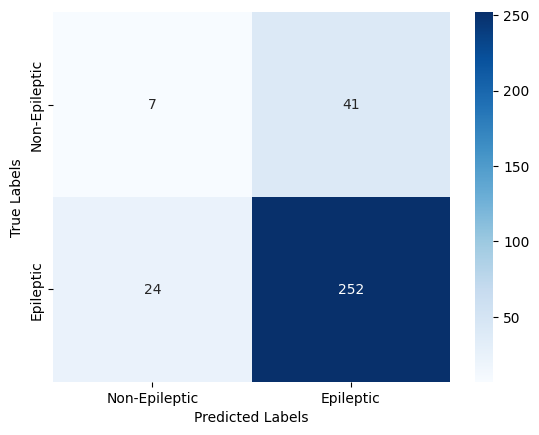

In [15]:
# Evaluate the model
svm = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

accuracy = svm.score(X_test, y_test)
print(classification_report(y_test, y_pred, target_names=["Non-Epileptic", "Epileptic"]))
print(f"SVM Accuracy: {accuracy * 100:.2f}%")
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Epileptic", "Epileptic"], yticklabels=["Non-Epileptic", "Epileptic"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### NN

In [28]:
class EEGFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Wrap your feature arrays
train_ds = EEGFeatureDataset(X_train, y_train)
val_ds = EEGFeatureDataset(X_val, y_val)
test_ds = EEGFeatureDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

In [29]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 2)  # binary classification

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.out(x)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

model = SimpleNN(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(100): 
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            val_loss = criterion(outputs, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model, "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


Training on: cuda
Epoch 1: Train Loss = 0.8317, Val Loss = 0.6932
Epoch 2: Train Loss = 0.7404, Val Loss = 0.6739
Epoch 3: Train Loss = 0.6972, Val Loss = 0.6577
Epoch 4: Train Loss = 0.7233, Val Loss = 0.6416
Epoch 5: Train Loss = 0.6819, Val Loss = 0.6270
Epoch 6: Train Loss = 0.6725, Val Loss = 0.6135
Epoch 7: Train Loss = 0.6666, Val Loss = 0.6011
Epoch 8: Train Loss = 0.6856, Val Loss = 0.5922
Epoch 9: Train Loss = 0.6647, Val Loss = 0.5802
Epoch 10: Train Loss = 0.6410, Val Loss = 0.5666
Epoch 11: Train Loss = 0.6473, Val Loss = 0.5534
Epoch 12: Train Loss = 0.6227, Val Loss = 0.5437
Epoch 13: Train Loss = 0.6675, Val Loss = 0.5390
Epoch 14: Train Loss = 0.6189, Val Loss = 0.5291
Epoch 15: Train Loss = 0.6237, Val Loss = 0.5204
Epoch 16: Train Loss = 0.6145, Val Loss = 0.5128
Epoch 17: Train Loss = 0.6019, Val Loss = 0.5056
Epoch 18: Train Loss = 0.6220, Val Loss = 0.4999
Epoch 19: Train Loss = 0.6257, Val Loss = 0.4910
Epoch 20: Train Loss = 0.5975, Val Loss = 0.4841
Epoch 21: T

               precision    recall  f1-score   support

Non-Epileptic       0.00      0.00      0.00        48
    Epileptic       0.85      1.00      0.92       276

     accuracy                           0.85       324
    macro avg       0.43      0.50      0.46       324
 weighted avg       0.73      0.85      0.78       324



C:\Users\filip\AppData\Local\Temp\ipykernel_34208\231514927.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model =torch.load(best_model_path)


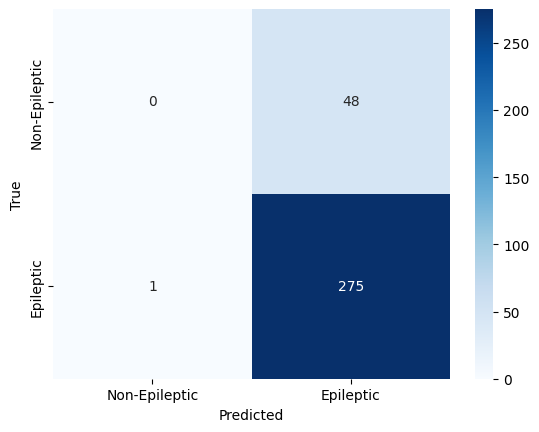

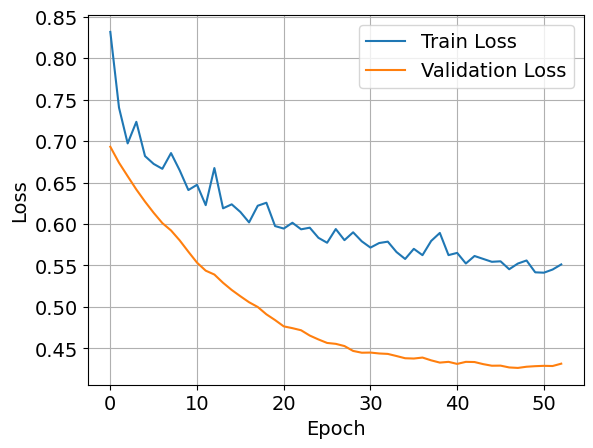

In [31]:
best_model_path = "best_model.pt"
model =torch.load(best_model_path)
model.to(device)
model.eval()
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in DataLoader(test_ds, batch_size=16):
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

print(classification_report(all_labels, all_preds, target_names=["Non-Epileptic", "Epileptic"]))




cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Epileptic", "Epileptic"], yticklabels=["Non-Epileptic", "Epileptic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# making all fontssize larger

plt.rcParams.update({'font.size': 14})



plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



### CNN

In [ ]:
def load_eeg_tensor(edf_path, max_len=3000, n_channels=19):
    try:
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        data = raw.get_data()

        # Ensure correct number of channels
        if data.shape[0] < n_channels:
            pad_ch = n_channels - data.shape[0]
            data = np.pad(data, ((0, pad_ch), (0, 0)), mode='constant')
        else:
            data = data[:n_channels, :]  # cut excess channels if too many

        # Clip or pad time dimension
        if data.shape[1] > max_len:
            data = data[:, :max_len]
        elif data.shape[1] < max_len:
            pad_len = max_len - data.shape[1]
            data = np.pad(data, ((0, 0), (0, pad_len)), mode='constant')

        # Normalize each channel independently
        data = (data - np.mean(data, axis=1, keepdims=True)) / (np.std(data, axis=1, keepdims=True) + 1e-6)

        return torch.tensor(data, dtype=torch.float32)

    except Exception as e:
        print(f"[ERROR] {edf_path}: {e}")
        return torch.zeros((n_channels, max_len), dtype=torch.float32)

    

from tqdm import tqdm
# Input: paths and labels
all_data = epilepsy_data + no_epilepsy_data
all_paths, all_labels = zip(*all_data)

# Output directory for tensors
preproc_root = "preprocessed"

# Output lists
preproc_paths = []
preproc_labels = []

for path, label in tqdm(zip(all_paths, all_labels), total=len(all_paths), desc="Preprocessing EDFs"):
    try:
        tensor = load_eeg_tensor(path, max_len=3000)

        # Build matching save path
        relative_path = os.path.relpath(path, start="00_epilepsy") if "00_epilepsy" in path else os.path.relpath(path, start="01_no_epilepsy")
        save_path = os.path.join(preproc_root, relative_path).replace(".edf", ".pt")
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Save tensor
        torch.save(tensor, save_path)

        preproc_paths.append(save_path)
        preproc_labels.append(label)

    except Exception as e:
        print(f" Failed to process {path}: {e}")

# Save final dataset list
torch.save({
    "paths": preproc_paths,
    "labels": preproc_labels
}, os.path.join(preproc_root, "preprocessed_index.pt"))

print(f" Preprocessed {len(preproc_paths)} files successfully.")



Preprocessing EDFs: 100%|██████████| 2236/2236 [07:55<00:00,  4.71it/s] 

 Preprocessed 2236 files successfully.


In [60]:


#use preprocessed tensors
class PreprocessedEEGDataset(torch.utils.data.Dataset):
    def __init__(self, pt_paths, labels):
        self.pt_paths = pt_paths
        self.labels = labels

    def __len__(self):
        return len(self.pt_paths)

    def __getitem__(self, idx):
        x = torch.load(self.pt_paths[idx])  # fast loading of preprocessed tensor
        y = self.labels[idx]
        return x, torch.tensor(y, dtype=torch.long)


In [61]:
# Convert EDF paths from subject-based splits to .pt paths
def edf_to_tensor_path(edf_path):
    return edf_path.replace(".edf", ".pt") \
                   .replace("00_epilepsy", "preprocessed") \
                   .replace("01_no_epilepsy", "preprocessed")

train_paths = [edf_to_tensor_path(p) for p, _ in train_data]
train_labels = [label for _, label in train_data]

val_paths = [edf_to_tensor_path(p) for p, _ in val_data]
val_labels = [label for _, label in val_data]

test_paths = [edf_to_tensor_path(p) for p, _ in test_data]
test_labels = [label for _, label in test_data]


In [62]:
train_ds = PreprocessedEEGDataset(train_paths, train_labels)
val_ds   = PreprocessedEEGDataset(val_paths, val_labels)
test_ds  = PreprocessedEEGDataset(test_paths, test_labels)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)
test_loader  = DataLoader(test_ds, batch_size=16)


In [63]:
max_len = 3000  
class EEGCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(19, 32, 7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * (max_len // 4), 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

model = EEGCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(100): 
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            val_loss = criterion(outputs, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            print(X_batch.shape, y_batch.shape)	
            break



Training on: cuda


C:\Users\filip\AppData\Local\Temp\ipykernel_34208\3720265369.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load(self.pt_paths[idx])  # fast loading of prepr

Epoch 1: Train Loss = 0.6529, Val Loss = 0.4960
Epoch 2: Train Loss = 0.5463, Val Loss = 0.3852
Epoch 3: Train Loss = 0.4707, Val Loss = 0.3953
Epoch 4: Train Loss = 0.4196, Val Loss = 0.4265
Epoch 5: Train Loss = 0.3500, Val Loss = 0.4673
Epoch 6: Train Loss = 0.3063, Val Loss = 0.5057
Epoch 7: Train Loss = 0.2698, Val Loss = 0.5165
Early stopping triggered at epoch 7
torch.Size([5, 19, 3000]) torch.Size([5])


C:\Users\filip\AppData\Local\Temp\ipykernel_34208\3146048818.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))
C:\Users\

               precision    recall  f1-score   support

Non-Epileptic       0.17      0.02      0.04        48
    Epileptic       0.85      0.98      0.91       276

     accuracy                           0.84       324
    macro avg       0.51      0.50      0.47       324
 weighted avg       0.75      0.84      0.78       324



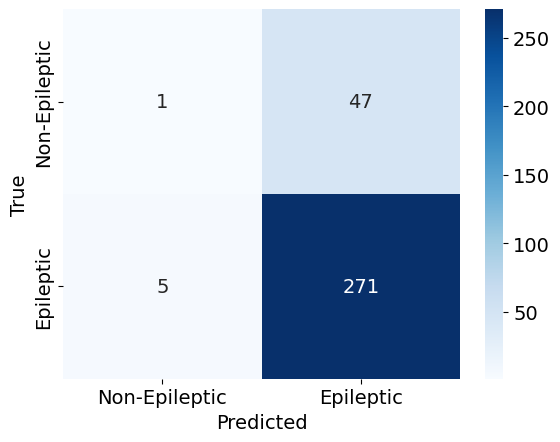

Test Accuracy: 83.95%


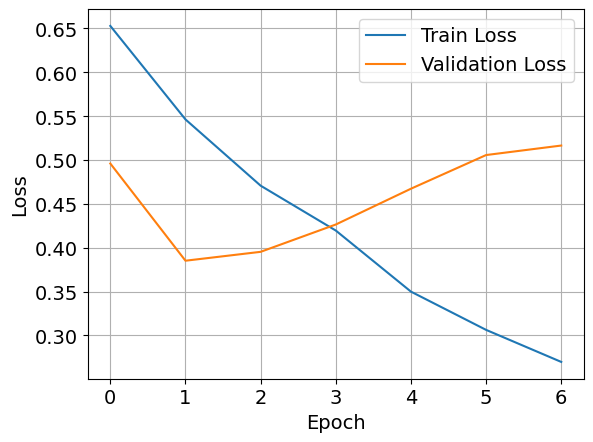

In [65]:
# ========== Run on Test Set ==========
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())


#all fontsize larger
plt.rcParams.update({'font.size': 14})


#for cnn
print(classification_report(all_labels, all_preds, target_names=["Non-Epileptic", "Epileptic"]))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Epileptic", "Epileptic"], yticklabels=["Non-Epileptic", "Epileptic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#all fontsize larger
plt.rcParams.update({'font.size': 14})
print(f"Test Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
